## Load the images

In [1]:
import os

input_dir = "../../Data/labeled_images/"
target_dir = "../../Data/labeled_images/"
NUM_CLASSES = 2
BATCH_SIZE = 16
EPOCHS = 10
DIM = 256

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

NUMBER_OF_SAMPLES = len(input_img_paths)
print("Number of samples:", NUMBER_OF_SAMPLES)

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 962
../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p1.jpg | ../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p1.jpg.png
../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p10.jpg | ../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p10.jpg.png
../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p100.jpg | ../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p100.jpg.png
../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p101.jpg | ../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p101.jpg.png
../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p102.jpg | ../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p102.jpg.png
../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p103.jpg | ../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p103.jpg.png
../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p104.jpg | ../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p104.jpg.png
../../Data/labeled_images/3DUS_L_probe1_conf1_ds1.dcm_p105.

## Vizualise the dataset

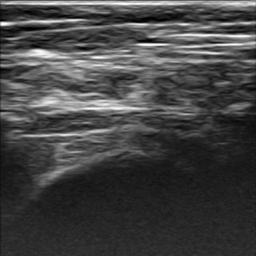

(256, 256, 3)


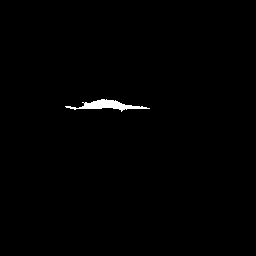

In [2]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Get the image shape
import cv2
im = cv2.imread(input_img_paths[9])
img_size = im.shape
print(img_size)

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Prepare Sequence class to load & vectorize batches of data

In [3]:
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from PIL import Image


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + (DIM, DIM, 3), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            img = cv2.resize(np.array(img), (DIM, DIM))
            x[j] = img
        y = np.zeros((self.batch_size,) + (DIM, DIM, 1), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size[:2], color_mode="grayscale")
            encoded_img = LabelEncoder().fit_transform(np.array(img).flatten()).reshape(img_size[:2]).astype('uint8')
            resized_img = cv2.resize(encoded_img, (DIM, DIM))
            y[j] = np.expand_dims(resized_img, axis=2)
            # print(y[j].shape)
            # y[j] = to_categorical(y[j], num_classes=NUM_CLASSES)
            # y[j] = to_categorical(img, num_classes=NUM_CLASSES)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j] = y[j] // 255
        y = to_categorical(y, num_classes=NUM_CLASSES)
        return x, y

## Load the trained models

In [4]:
from models.vgg16 import get_model

model = get_model(input_shape=(DIM, DIM, 3), num_classes=NUM_CLASSES)
# vgg16 = vgg16.load_weights('trained-models/synovial-bone/TRANSFER_LEARNING_VGG16.hdf5')

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 256, 256, 3)  0          ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 256, 256, 3)  0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                      

## Set aside a validation split

(256, 256, 3)


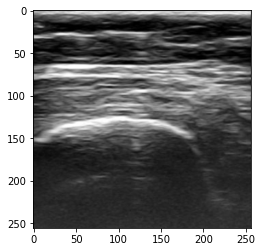

In [5]:
import random

# Split our img paths into a training and a validation set
val_samples = round(0.1 * NUMBER_OF_SAMPLES)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    BATCH_SIZE, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(BATCH_SIZE, img_size, val_input_img_paths, val_target_img_paths)
import matplotlib.pyplot as plt
print(np.shape(train_gen[1][0][3]))
plt.imshow(train_gen[1][0][3]/255)

## Train the model

In [6]:
# Configure the model for training.
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU
import time
patience = 5
monitor='val_accuracy'
mode='max'
#some train parameters and metrics
optimizer = keras.optimizers.Adam(learning_rate=1e-4, name="Adam")
loss = "categorical_crossentropy"
metrics = [
    "accuracy",
    keras.metrics.IoU(
        num_classes=NUM_CLASSES,
        target_class_ids=[
            0
        ],
        name="binary_iou0",
    ),
    keras.metrics.IoU(
        num_classes=NUM_CLASSES,
        target_class_ids=[1],
        name="binary_iou1",
    ),
    # keras.metrics.IoU(
    #     num_classes=NUM_CLASSES,
    #     target_class_ids=[2],
    #     name="binary_iou2",
    # ),
    keras.metrics.MeanIoU(num_classes=NUM_CLASSES, name="mean_iou"),
    keras.metrics.Precision(name="precision0", class_id=0),
    keras.metrics.Precision(name="precision1", class_id=1),
    # keras.metrics.Precision(name="precision2", class_id=2),
    keras.metrics.Recall(name="recall0", class_id=0),
    keras.metrics.Recall(name="recall1", class_id=1),
    # keras.metrics.Recall(name="recall2", class_id=2),
    keras.metrics.AUC(
        curve='PR',
        summation_method='interpolation',
        name='auc',
        multi_label=False,
    )

]

#compile model
model.compile(
    optimizer=optimizer, loss=loss,  metrics=metrics, #loss_weights=class_weights,
)

# #some fitting callbacks
# checkpoint_path = model_dir + "/" + MODEL_NAME + ".hdf5"
# mode = "max"
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path, verbose=1, monitor=monitor, mode=mode, save_best_only=True
# )

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(
#     log_dir=log_dir, histogram_freq=1
# )

early_stopping = EarlyStopping(
    monitor=monitor, mode=mode, patience=patience, verbose=1)
# callbacks = [tensorboard_callback, cp_callback, early_stopping]
callbacks = [early_stopping]

#fit model
start = time.time()
history_TL = model.fit(
    train_gen,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=val_gen,
    callbacks=callbacks,
)
stop = time.time()
timeTL = stop - start
print(f"Fit TL time: {timeTL}s")
#update history
history_dict = history_TL.history

Epoch 1/10
54/54 - 63s - loss: 0.4631 - accuracy: 0.9891 - binary_iou0: 0.9752 - binary_iou1: 0.9749 - mean_iou: 0.9751 - precision0: 0.9946 - precision1: 0.4063 - recall0: 0.9944 - recall1: 0.4140 - auc: 0.9878 - val_loss: 0.1965 - val_accuracy: 0.9931 - val_binary_iou0: 0.9841 - val_binary_iou1: 0.9840 - val_mean_iou: 0.9840 - val_precision0: 0.9952 - val_precision1: 0.6779 - val_recall0: 0.9978 - val_recall1: 0.4964 - val_auc: 0.9924 - 63s/epoch - 1s/step
Epoch 2/10
54/54 - 33s - loss: 0.1478 - accuracy: 0.9927 - binary_iou0: 0.9813 - binary_iou1: 0.9810 - mean_iou: 0.9812 - precision0: 0.9962 - precision1: 0.6002 - recall0: 0.9964 - recall1: 0.5926 - auc: 0.9925 - val_loss: 0.1441 - val_accuracy: 0.9910 - val_binary_iou0: 0.9757 - val_binary_iou1: 0.9752 - val_mean_iou: 0.9754 - val_precision0: 0.9975 - val_precision1: 0.5140 - val_recall0: 0.9934 - val_recall1: 0.7407 - val_auc: 0.9913 - 33s/epoch - 619ms/step
Epoch 3/10
54/54 - 33s - loss: 0.1080 - accuracy: 0.9931 - binary_iou0:

## Fine tune the model

In [7]:
model.trainable = True
# re-compile
optimizer = keras.optimizers.Adam(learning_rate=1e-7, name="Adam")
model.compile(
    optimizer=optimizer, loss=loss, metrics=metrics
)

start = time.time()
history_FT = model.fit(
    train_gen,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=val_gen,
    callbacks=callbacks,
)
stop = time.time()
timeFT = stop - start

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/VGG16_U-Net/conv2d_8/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Antony\AppData\Local\Temp\ipykernel_20828\405951494.py", line 9, in <cell line: 9>
      history_FT = model.fit(
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "c:\Users\Antony\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/VGG16_U-Net/conv2d_8/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[16,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/VGG16_U-Net/conv2d_8/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_18646]

## Visualize predictions

6/6 [==============================] - 2s 271ms/step


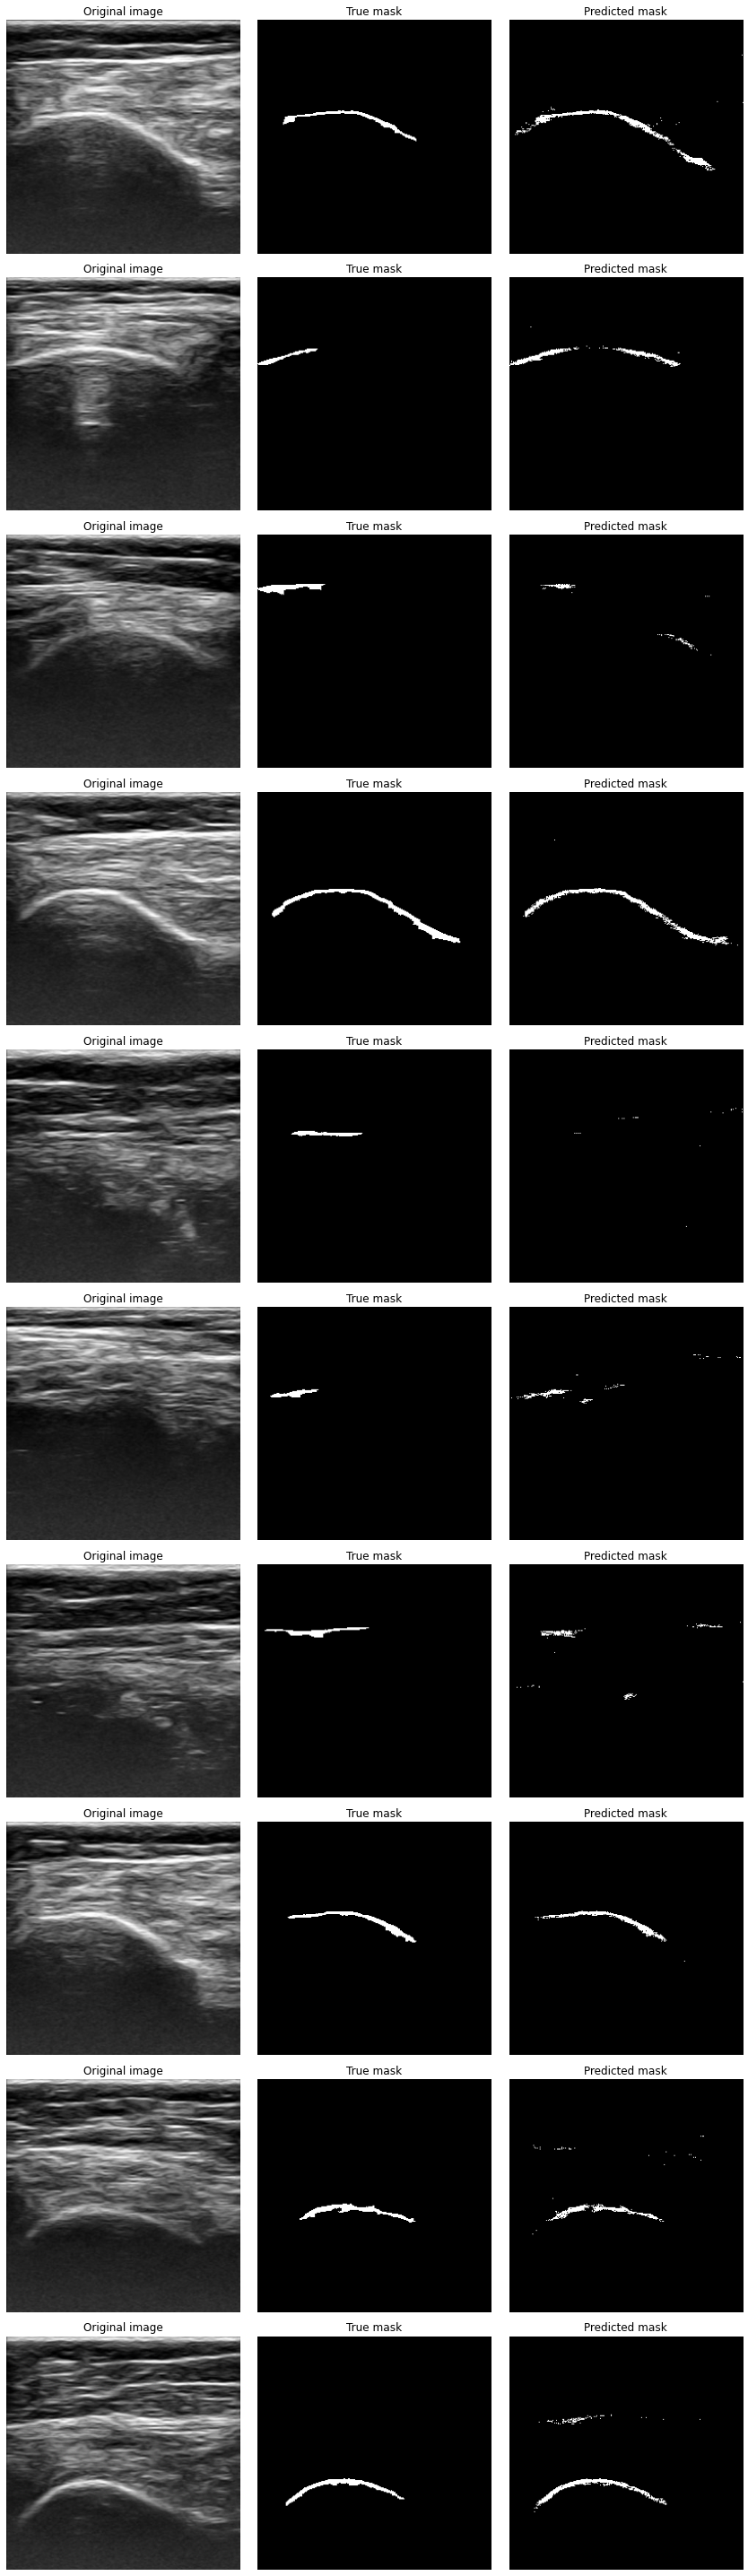

In [12]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(BATCH_SIZE, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img
    # display(img)


# Display results for validation image #10
img_set = 10

# Display input image
# from IPython.display import Image, display
from PIL import Image
display_size = 4
fig, axes = plt.subplots(img_set, 3, figsize=(3*display_size, img_set*display_size))
for i in range(img_set):
    img = cv2.resize(cv2.imread(val_input_img_paths[i]), (DIM, DIM))
    img_true = cv2.resize(np.array(ImageOps.autocontrast(load_img(val_target_img_paths[i]))), (DIM, DIM))
    img_pred = display_mask(i)

    # axes[0, i] = plt.imshow(img)
    # axes[i, 1] = plt.imshow(img_true)
    # if i == 0:
    axes[i, 0].set_title("Original image")
    axes[i, 1].set_title("True mask")
    axes[i, 2].set_title("Predicted mask")
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(img_true, cmap='gray')
    axes[i, 2].imshow(img_pred, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
# fig.suptitle("Prediction results")
fig.tight_layout()
plt.show()

# display(Image(filename=val_input_img_paths[i]))

# # Display ground-truth target mask
# img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
# display(img)

# # Display mask predicted by our model
# display_mask(i)  # Note that the model only sees inputs at 150x150.